# Ames Housing Price Prediction

## Regression

In this notebook, I will explore various normal and regularised regression models to determine an effective model for predicting house prices in Ames, Iowa.

## Import and clean

In [598]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [599]:
# load the data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [600]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [601]:
# Number of null records
print('Num null values in training set:', np.sum(train.isnull().sum()))
print('Num null values in test set:', np.sum(test.isnull().sum()))

train.isnull().sum().sort_values(ascending=False).apply(lambda x: x / len(train)).head(5)

Num null values in training set: 6965
Num null values in test set: 7000


PoolQC         0.995205
MiscFeature    0.963014
Alley          0.937671
Fence          0.807534
FireplaceQu    0.472603
dtype: float64

In [602]:
test.isnull().sum().sort_values(ascending=False).apply(lambda x: x / len(test)).head(5)

PoolQC         0.997944
MiscFeature    0.965045
Alley          0.926662
Fence          0.801234
FireplaceQu    0.500343
dtype: float64

In [603]:
def cols_startswith(columns, value, exclude=[]):
    return [x for x in columns if x.startswith(value) and x not in exclude]

def clean(df):
    # All except FireplaceQu >80% missing values
    cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
    df[cols] = df[cols].fillna('None')

    # ~50% missing values - fill with mean
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())

    # Garage
    garage_num_cols = ['GarageArea', 'GarageCars']
    garage_cols = cols_startswith(df.columns, 'Garage', garage_num_cols)
    df[garage_cols] = df[garage_cols].fillna('None')
    for x in garage_num_cols:
        df[x] = df[x].fillna(df[x].mean())
    
    # Basement
    basement_num_cols = ['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath']
    basement_cols = cols_startswith(df.columns, 'Bsmt', basement_num_cols)
    df[basement_cols] = df[basement_cols].fillna('None')
    df[basement_num_cols] = df[basement_num_cols].fillna(0)

    # MasVnr
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

    # For remaining columns, if numerical fill with mean, if categorical/string/object fill with most common
    remaining_null_cols = df.columns[df.isnull().any()]
    for x in remaining_null_cols:
        if df[x].dtype in (np.float64, np.int64):
            df[x] = df[x].fillna(df[x].mean())
        else:
            df[x] = df[x].fillna(df[x].mode().iloc[0])

    return df

In [604]:
train, test = clean(train), clean(test)

print('Num null values in training set:', np.sum(train.isnull().sum()))
print('Num null values in test set:', np.sum(test.isnull().sum()))

Num null values in training set: 0
Num null values in test set: 0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,4.110874,RL,4.189655,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,None,None,0.000000,2,2008,WD,Normal,2.583824
1,3.044522,RL,4.394449,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,...,0.0,None,None,None,0.000000,5,2007,WD,Normal,2.573300
2,4.110874,RL,4.234107,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,...,0.0,None,None,None,0.000000,9,2008,WD,Normal,2.589054
3,4.262680,RL,4.110874,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,...,0.0,None,None,None,0.000000,2,2006,WD,Abnorml,2.553297
4,4.110874,RL,4.442651,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,...,0.0,None,None,None,0.000000,12,2008,WD,Normal,2.597433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.110874,RL,4.143135,8.976894,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,None,None,0.000000,8,2007,WD,Normal,2.570514
1456,3.044522,RL,4.454347,9.486152,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,MnPrv,None,0.000000,2,2010,WD,Normal,2.584365
1457,4.262680,RL,4.204693,9.109746,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,GdPrv,Shed,2.177526,5,2010,WD,Normal,2.602181
1458,3.044522,RL,4.234107,9.181735,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,None,None,0.000000,4,2010,WD,Normal,2.554469


In [605]:
# Drop useless ID column
train = train.drop('Id', axis=1)

## Target variable

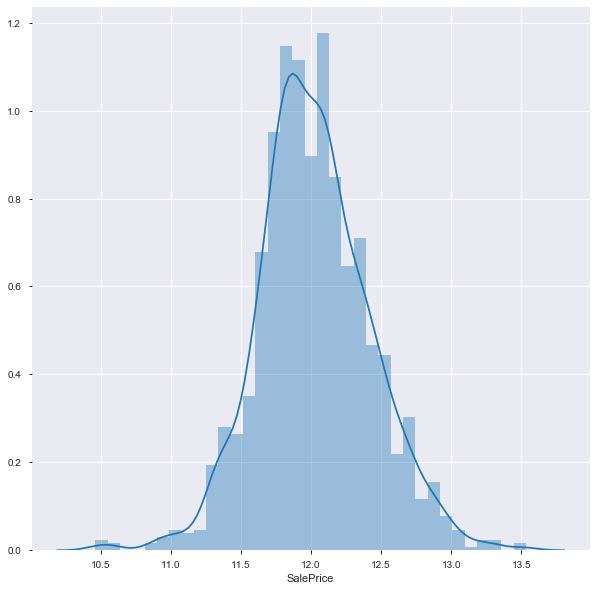

In [606]:
# Log transform SalePrice

train['SalePrice'] = np.log1p(train['SalePrice'])

plt.figure(figsize=(10,10))
sns.distplot(train['SalePrice'])

## EDA and feature transformation



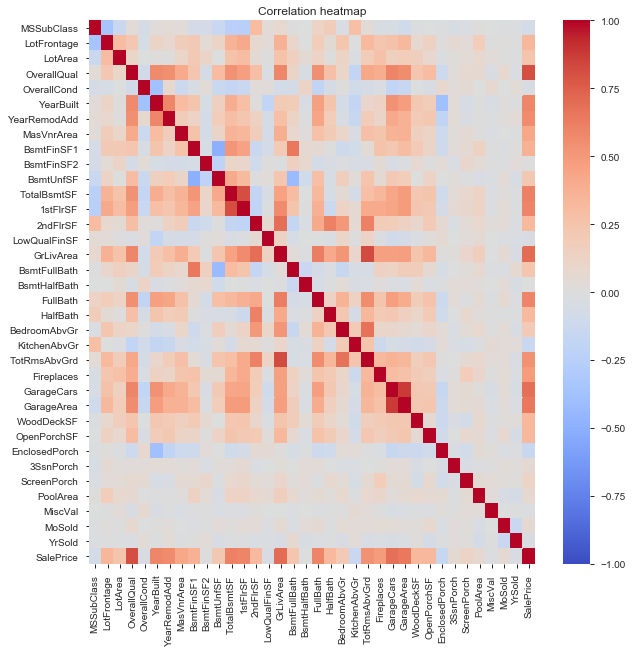

In [607]:
overall_corr = train.corr()
saleprice_corr = overall_corr[['SalePrice']].sort_values(by='SalePrice', ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(overall_corr, cmap='coolwarm', vmax=1, vmin=-1).set_title('Correlation heatmap')
plt.show()

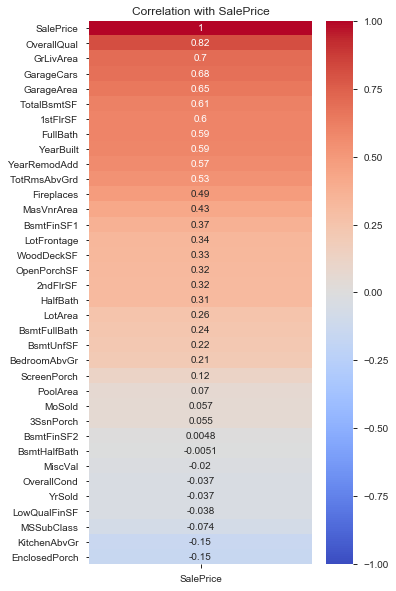

In [608]:
plt.figure(figsize=(5,10))
sns.heatmap(saleprice_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1).set_title('Correlation with SalePrice')
plt.show()

There are a number of features that correlate well with SalePrice, which are good for a regression model, however there is a decent degree of multicolinearity which can cause model coefficients to become statistically insignificant as it increases the coefficient standard errors.

In [609]:
from scipy.stats import skew

# Log transforming skewed features
numerical_columns = [x for x in train.columns if train[x].dtype in (np.float64, np.int64)]

skewed_cols = train[numerical_columns].apply(lambda x: skew(x))
skewed_cols = skewed_cols[skewed_cols > 0.75].index

train[skewed_cols] = train[skewed_cols].apply(np.log1p)
test[skewed_cols] = test[skewed_cols].apply(np.log1p) # also apply to test set

In [610]:
# Create one hot encoded features
all_data = pd.concat([train, test])
all_data = pd.get_dummies(all_data)

train = all_data[:train.shape[0]]
test = all_data[train.shape[0]:]

train = train.drop('Id', axis=1)